# Tutorial to create a saliency map #

In [1]:
%load_ext autoreload
%autoreload 2
%cd -q ..

import sys
import os

from Bio import SeqIO
from evoaug_tf import evoaug, augment
from src.deepExplain_tool import getDeepExplainerBackground, deepExplain, plotResults
from src.diff_expression_model import load_model, get_siamese_model
import numpy as np
import importlib
import pickle


2025-05-22 10:33:00.484828: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-22 10:33:00.610187: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-22 10:33:00.614887: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /mnt/modules/easybuild/software/Gho

Retrieve the siamese model based on the weight of Helder

In [2]:

model_path = "data/model_single.json"
weights_path = "data/weights_single.h5"

augment_list = [
	augment.RandomRC(rc_prob=0.5),
	augment.RandomInsertionBatch(insert_min=0, insert_max=20),
	augment.RandomDeletion(delete_min=0, delete_max=30),
	augment.RandomTranslocationBatch(shift_min=0, shift_max=20),
	augment.RandomMutation(mutate_frac=0.05),
	augment.RandomNoise()
]

model = load_model(model_path, weights_path)
siamese_model = get_siamese_model(model)


2025-05-22 10:33:15.040354: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /mnt/modules/easybuild/software/Ghostscript/10.01.2-GCCcore-12.3.0/lib:/mnt/modules/easybuild/software/GTK3/3.24.37-GCCcore-12.3.0/lib:/mnt/modules/easybuild/software/Wayland/1.22.0-GCCcore-12.3.0/lib:/mnt/modules/easybuild/software/libepoxy/1.5.10-GCCcore-12.3.0/lib:/mnt/modules/easybuild/software/Mesa/23.1.4-GCCcore-12.3.0/lib:/mnt/modules/easybuild/software/LLVM/16.0.6-GCCcore-12.3.0/lib:/mnt/modules/easybuild/software/libunwind/1.6.2-GCCcore-12.3.0/lib:/mnt/modules/easybuild/software/libglvnd/1.6.0-GCCcore-12.3.0/lib:/mnt/modules/easybuild/software/libdrm/2.4.115-GCCcore-12.3.0/lib:/mnt/modules/easybuild/software/Pango/1.50.14-GCCcore-12.3.0/lib:/mnt/modules/easybuild/software/FriBidi/1.0.12-GCCcore-12.3.0/lib:/mnt/modules/easybuild/so


Loaded model from disk


Generate a background based on N random samples. In our case we start from a pickle containing 100 one-hot-encoded sequences with both the forward and reverse strand.

The numpy array passed to getDeepExplainerBackground should have the following shape (2, #samples, #sequence length, 4)

In [3]:
bg_path = "data/background_100samples.pkl"
with open(bg_path, 'rb') as f:
    background_data = pickle.load(f)

# Conver to numpy
np_bg = np.array(background_data)

# Remove axis of dimension 1
np_bg = np.squeeze(np_bg)

# Convert to float 64, to be compatible with deepExplain
np_bg = np.float64(np_bg)

background = getDeepExplainerBackground(background_samples=np_bg, shuffle=False, post_hoc_conjoining=True)

The genes for which we want to create a logo

In [4]:
gene_ids_to_explain = [
	'AT3G46120::Chr3:16938040-16938660(-)',
	'AT2G02695::Chr2:752586-753206(-)',
	'AT4G16280::Chr4:9212576-9213196(-)']

Retrieve the sequences, to speed up the SeqIO parsing you could chunk larger fasta files

In [5]:
sequence_list = []
gene_id_list = []

for chunk in range(1,3):
	fasta_path = f"data/fasta/example.fasta_c{chunk}"
	fasta_sequences = SeqIO.parse(open(fasta_path),'fasta')
	for fasta in fasta_sequences:
		name, sequence = fasta.id, str(fasta.seq)
		if name in gene_ids_to_explain:
			gene_id_list.append(name)
			sequence_list.append(sequence)

One hot encode the sequences and creat ethe reverse compliment

In [6]:
ohe_list = []
ohe_rc_list = []
for sequence in sequence_list:
	ohe_seq = []
	ohe_rc_seq = []
	for i in sequence:
		if i == 'A':
			ohe_seq.append([1., 0., 0., 0.])
			ohe_rc_seq.append([0., 0., 0., 1.])
		elif i == 'C':
			ohe_seq.append([0., 1., 0., 0.])
			ohe_rc_seq.append([0., 0., 1., 0.])
		elif i == 'G':
			ohe_seq.append([0., 0., 1., 0.])
			ohe_rc_seq.append([0., 1., 0., 0.])
		elif i == 'T':
			ohe_seq.append([0., 0., 0., 1.])
			ohe_rc_seq.append([1., 0., 0., 0.])
		else:
			ohe_seq.append([0., 0., 0., 0.])
			ohe_rc_seq.append([0., 0., 0., 0.])
	ohe_list.append(ohe_seq)
	ohe_rc_list.append(list(reversed(ohe_rc_seq)))
ohe_np = np.array(ohe_list)
ohe_rc_np = np.array(ohe_rc_list)

np_deepexplain_samples = np.stack((ohe_np, ohe_rc_np))

In [10]:
shap_values = deepExplain(samples=np_deepexplain_samples,
                          loaded_model=siamese_model, 
                          bg=background, 
                          post_hoc_conjoining=True, 
                          augment_list=augment_list, 
                          pad_background=True, 
                          pad_samples=False,
                          remove_evo_aug_padding=False)

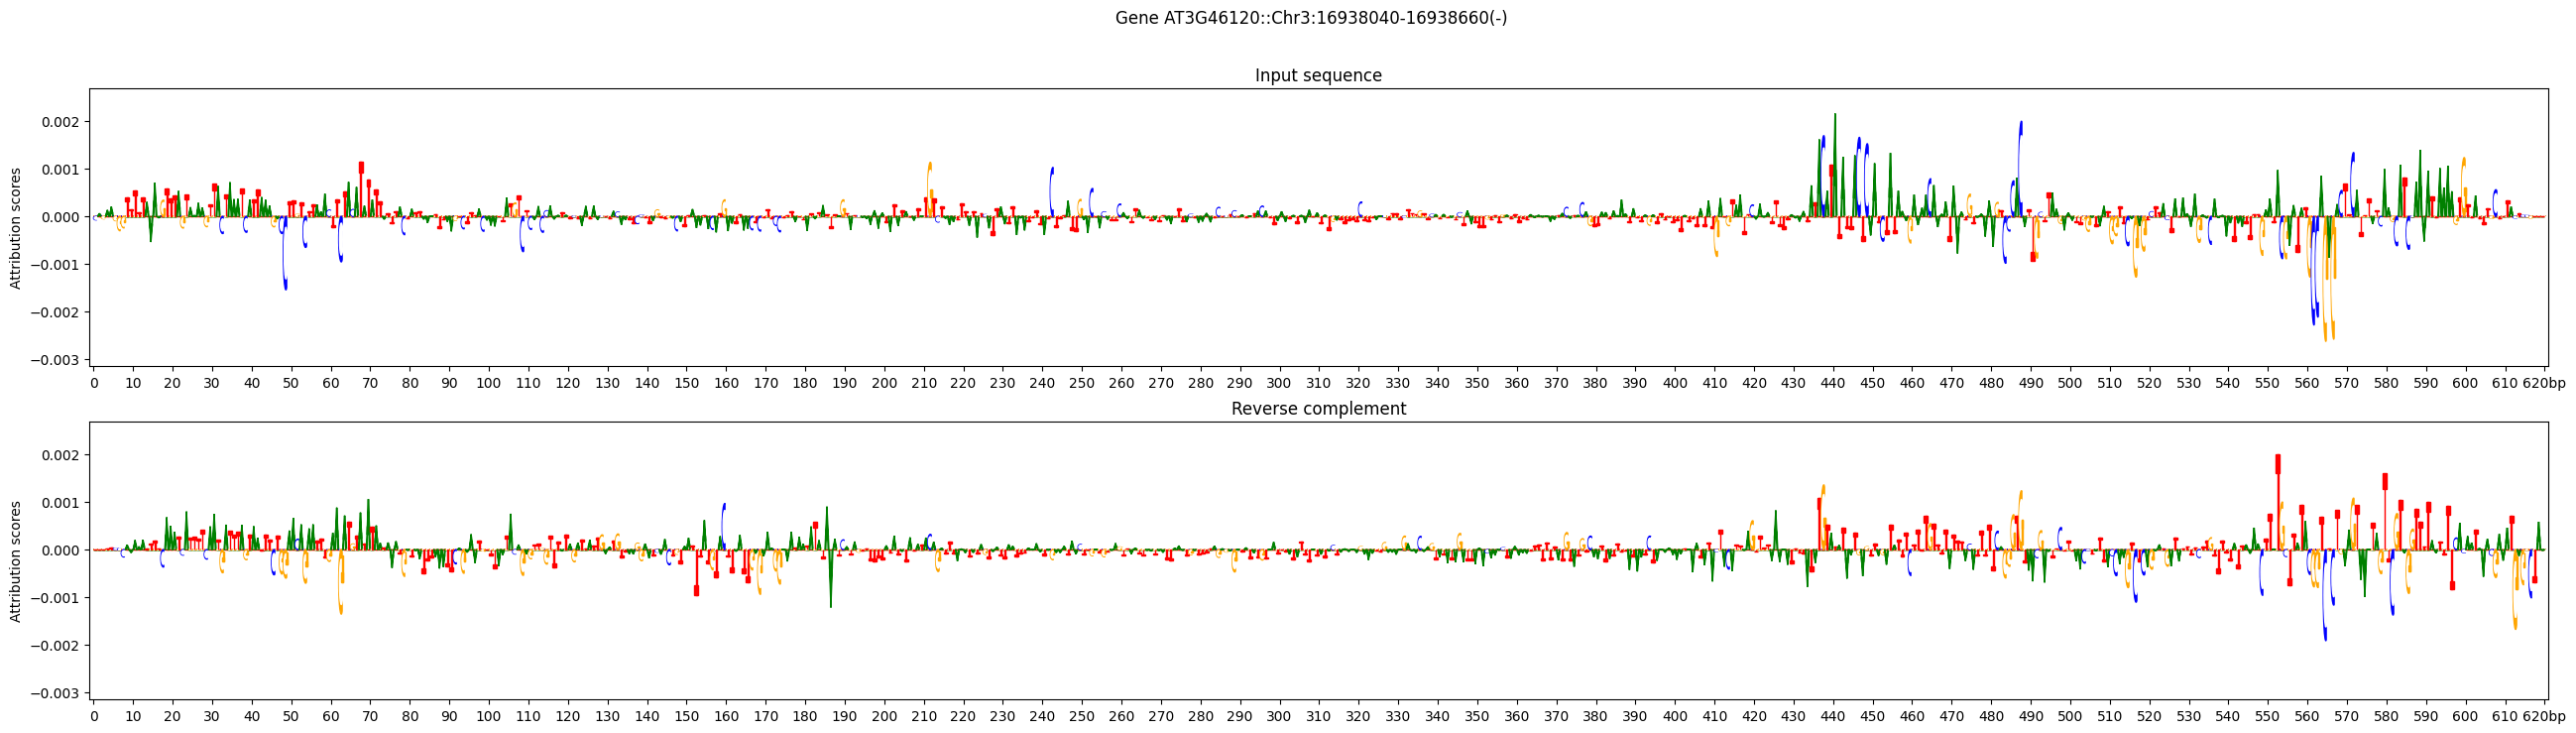

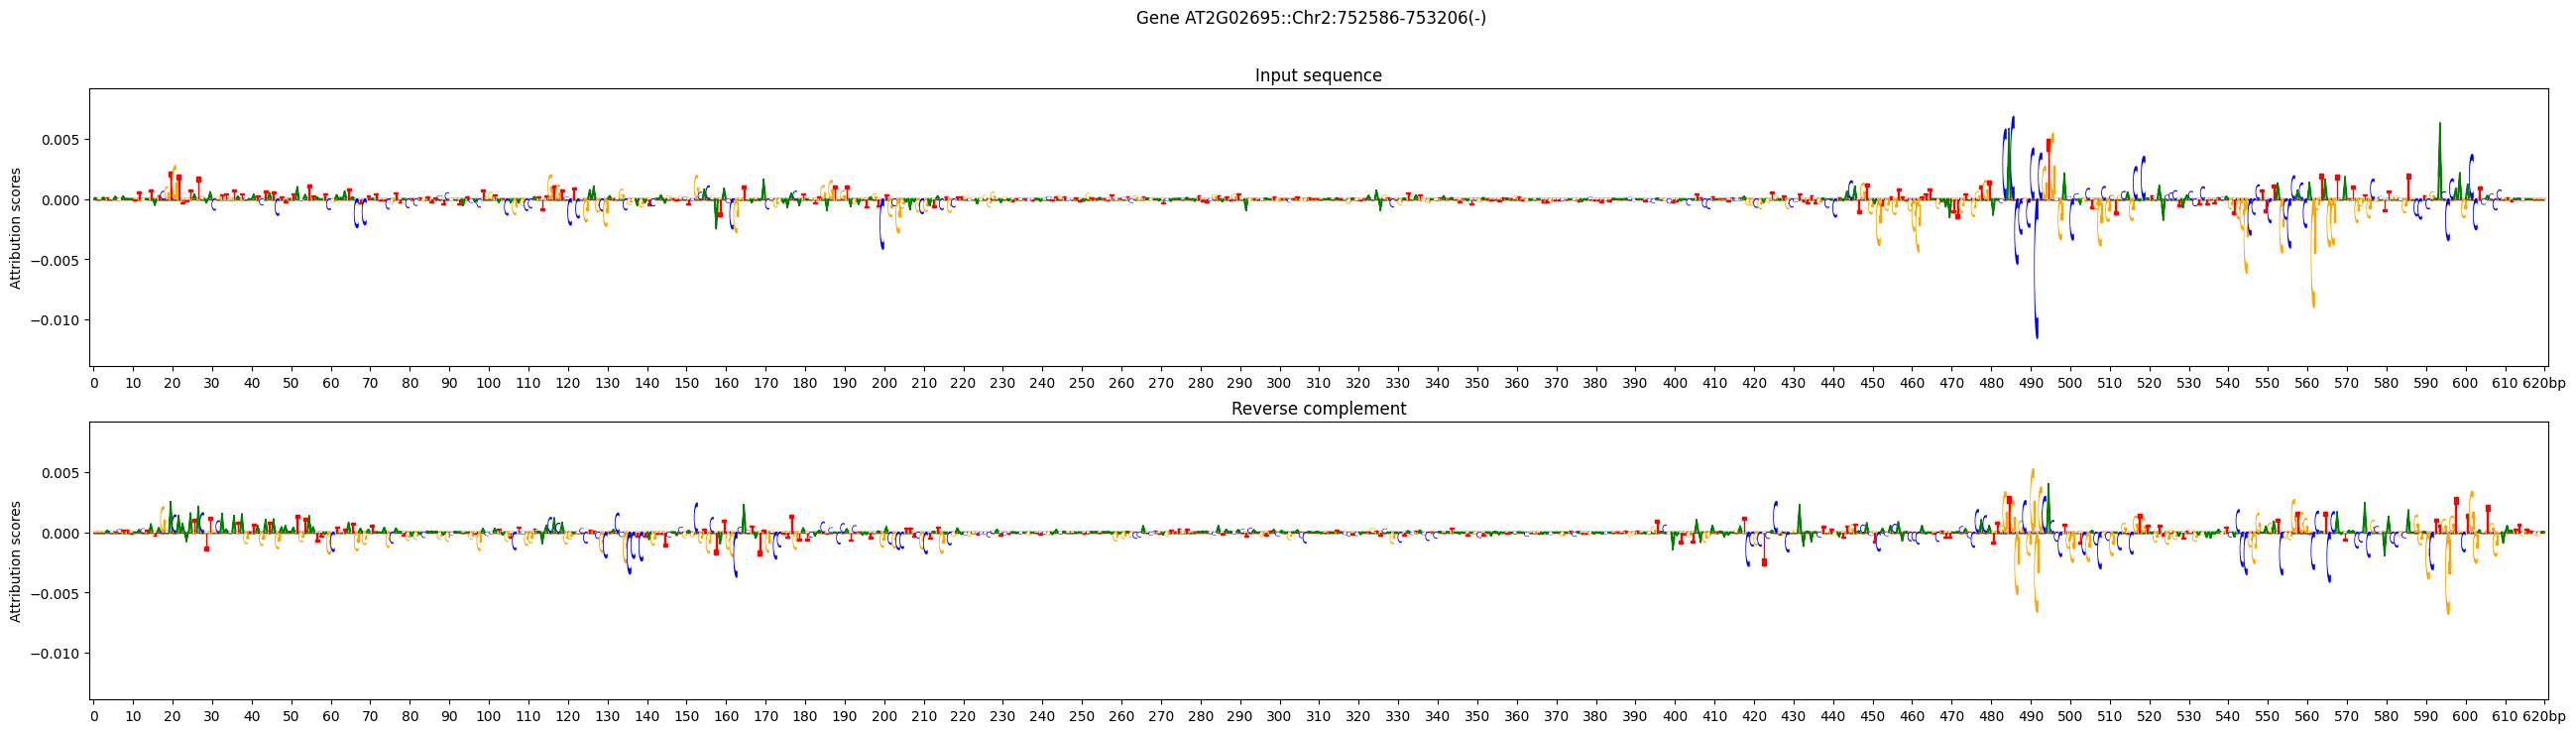

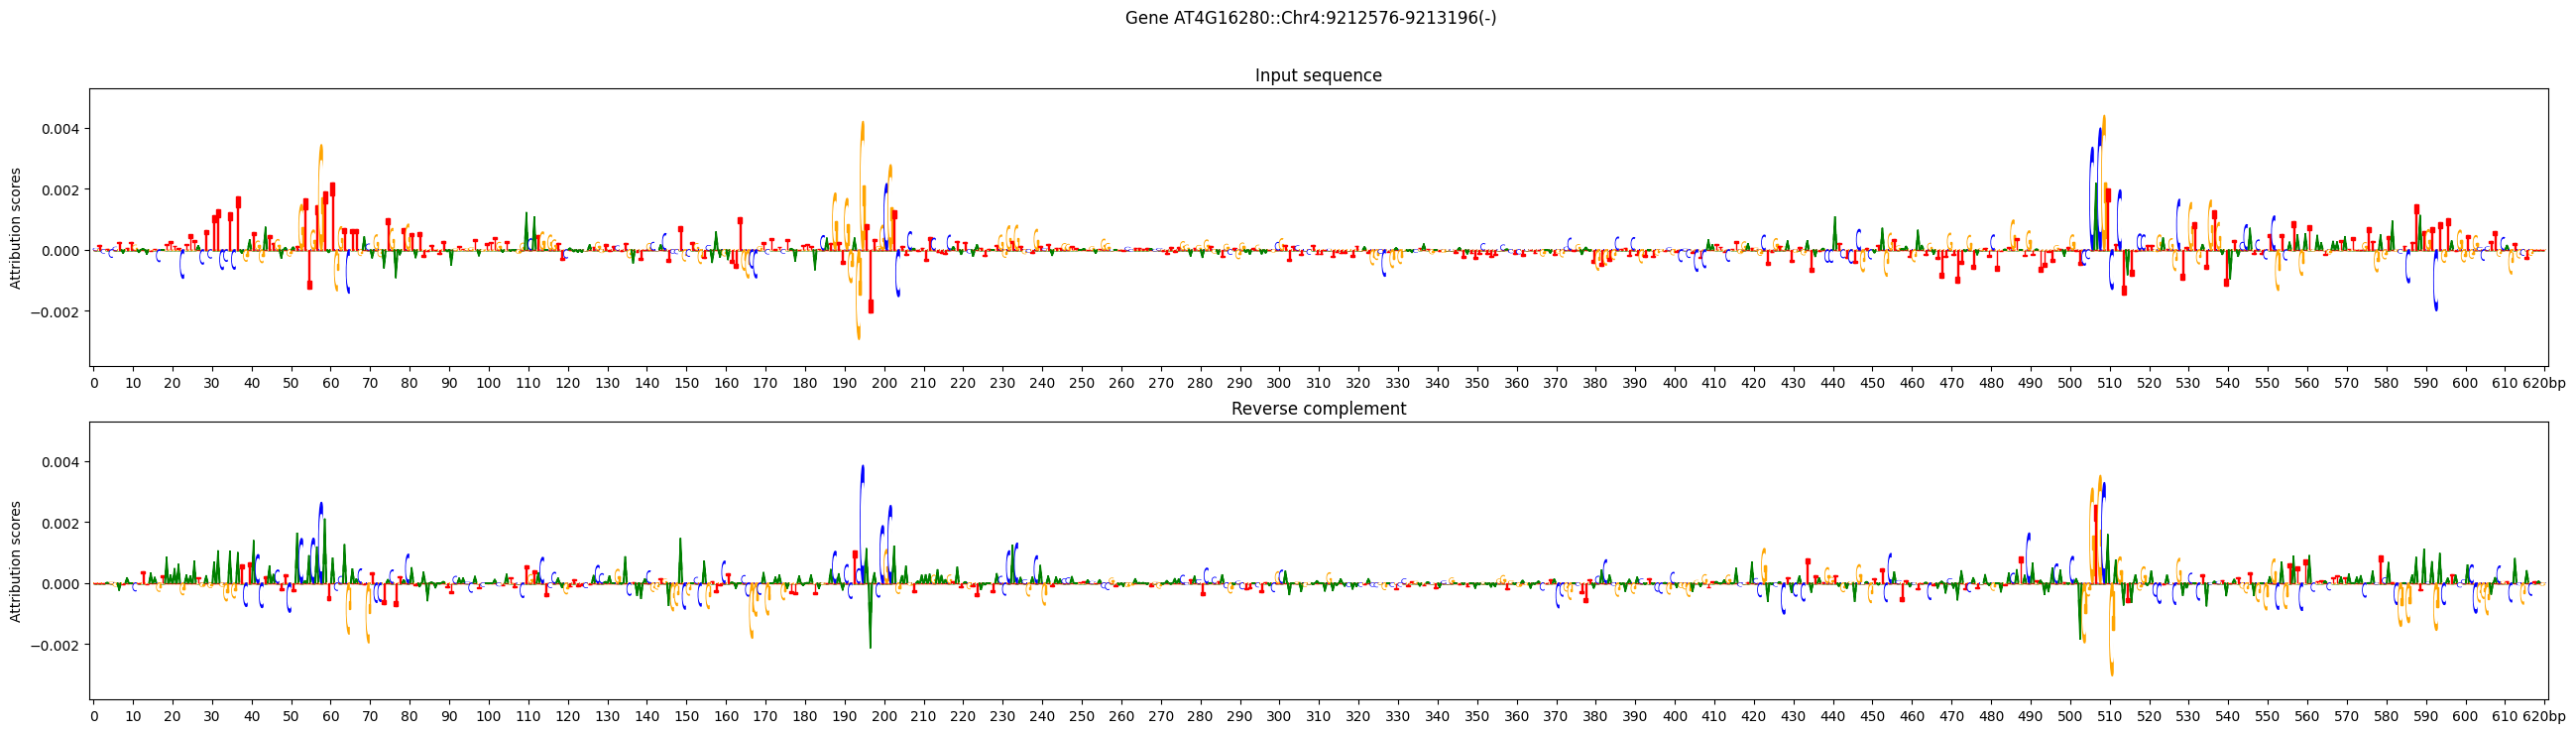

In [11]:
plotResults(shap_values=shap_values, 
            samples=np_deepexplain_samples, 
            post_hoc_conjoining=True, 
            gene_ids=gene_ids_to_explain,
            in_silico_mut=False,
            model=siamese_model
)